In [ ]:
# Step 1: Environment Setup and Basic Download Test

# Install necessary libraries quietly
!pip install vitaldb matplotlib awscli xgboost scikit-learn --quiet

import os
import vitaldb

# Define a temporary directory for a single test file
TEST_DIR = 'temp_test_vital_file'
os.makedirs(TEST_DIR, exist_ok=True)

# Define the path for a single test file (e.g., 0001.vital)
TEST_CASE_ID = 1
TEST_FILENAME = f'{TEST_CASE_ID:04d}.vital'
TEST_FILE_PATH = os.path.join(TEST_DIR, TEST_FILENAME)
S3_SOURCE_PATH = f's3://physionet-open/vitaldb/1.0.0/vital_files/{TEST_FILENAME}'

print(f"Attempting to download {TEST_FILENAME} to {TEST_FILE_PATH}...")

# Remove existing file to ensure a fresh download
if os.path.exists(TEST_FILE_PATH):
    os.remove(TEST_FILE_PATH)
    print(f"Removed existing {TEST_FILENAME}.")

# Download the file
download_command = f'aws s3 cp --no-sign-request {S3_SOURCE_PATH} {TEST_FILE_PATH}'
os.system(download_command)

# Verify download
if os.path.exists(TEST_FILE_PATH):
    print(f"SUCCESS: {TEST_FILENAME} downloaded successfully.")
    # Optional: Try to open it with vitaldb to confirm it's valid
    try:
        vf = vitaldb.VitalFile(TEST_FILE_PATH)
        print(f"SUCCESS: {TEST_FILENAME} can be opened by vitaldb. It has {len(vf.get_track_names())} tracks.")
    except Exception as e:
        print(f"WARNING: Could not open {TEST_FILENAME} with vitaldb: {e}")
else:
    print(f"ERROR: {TEST_FILENAME} was NOT downloaded.")

# Clean up the test file and directory
if os.path.exists(TEST_FILE_PATH):
    os.remove(TEST_FILE_PATH)
    print(f"Cleaned up {TEST_FILENAME}.")
if os.path.exists(TEST_DIR):
    os.rmdir(TEST_DIR)
    print(f"Cleaned up directory {TEST_DIR}.")

print("\nStep 1 complete. Please review the output for success messages.")

In [ ]:
# Step 2: Feature Engineering Logic Test (Single Patient)

import os
import vitaldb
import pandas as pd
import numpy as np

# --- Configuration Parameters (re-defined for this cell's context) ---
VITAL_FILES_LOCAL_DIR = 'temp_feature_test' # Temporary directory for this test
INPUT_VITALS = [
    'Solar8000/HR',
    'Solar8000/ART_MBP',
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2'
]
TARGET_VITAL = 'BIS/BIS'
TRACKS_FOR_MODEL = INPUT_VITALS + [TARGET_VITAL, 'EVENT']
ROLLING_WINDOW_SIZE = 300 # 5 minutes in seconds for feature engineering

# --- Helper Functions (from previous code) ---
def calculate_slope(y):
    """Calculates the slope of a series, handling NaNs."""
    y_clean = y.dropna()
    if len(y_clean) < 2:
        return np.nan
    return np.polyfit(np.arange(len(y_clean)), y_clean, 1)[0]

def generate_patient_features(case_ids: list, vital_files_dir: str, tracks_to_load: list,
                               window_size: int, input_vitals: list, target_vital: str):
    """
    Generator function to load patient data, engineer features, and yield processed DataFrames.
    (Simplified for single-patient test, but designed for iteration)
    """
    feature_cols_template = []
    for col in input_vitals:
        feature_cols_template.extend([
            f'{col}_mean', f'{col}_std', f'{col}_min', f'{col}_max', f'{col}_trend'
        ])

    for case_id in case_ids: # This loop will run only once for our test
        case_filename = f'{case_id:04d}.vital'
        file_path = os.path.join(vital_files_dir, case_filename)

        if not os.path.exists(file_path):
            print(f"Warning: File '{file_path}' not found for Case {case_id}. Skipping.")
            continue

        try:
            vf = vitaldb.VitalFile(file_path)
            df_raw = vf.to_pandas(tracks_to_load, interval=1)

            df_model = df_raw.copy()

            # Perform feature engineering
            for col in input_vitals:
                df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
                df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
                df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
                df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
                df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)

            feature_cols = [f for f in feature_cols_template if f in df_model.columns]
            final_cols = feature_cols + [target_vital]
            df_processed = df_model[final_cols].copy()

            # Drop rows where the target is NaN or where all features are NaN
            df_processed = df_processed.dropna(subset=[target_vital]).dropna(how='all', subset=feature_cols)

            if not df_processed.empty:
                yield df_processed
            else:
                print(f"No valid data points after feature engineering for Case {case_id}. Skipping.")

        except Exception as e:
            print(f"Error processing Case {case_id}: {e}. Skipping.")

# --- Test Execution for Step 2 ---
TEST_CASE_ID = 1
TEST_DIR = 'temp_feature_test'
TEST_FILENAME = f'{TEST_CASE_ID:04d}.vital'
TEST_FILE_PATH = os.path.join(TEST_DIR, TEST_FILENAME)
S3_SOURCE_PATH = f's3://physionet-open/vitaldb/1.0.0/vital_files/{TEST_FILENAME}'

# Ensure directory exists and download the test file
os.makedirs(TEST_DIR, exist_ok=True)
if not os.path.exists(TEST_FILE_PATH):
    download_command = f'aws s3 cp --no-sign-request {S3_SOURCE_PATH} {TEST_FILE_PATH}'
    os.system(download_command)
    print(f"Downloaded {TEST_FILENAME} for feature engineering test.")
else:
    print(f"Using existing {TEST_FILENAME} for feature engineering test.")

# Generate features for the single test case
print(f"\nGenerating features for Case {TEST_CASE_ID}...")
processed_dfs = list(generate_patient_features(
    [TEST_CASE_ID], TEST_DIR, TRACKS_FOR_MODEL, ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL
))

if processed_dfs:
    test_df = processed_dfs[0]
    print(f"\nSUCCESS: Processed DataFrame shape: {test_df.shape}")
    print("First 5 rows of processed data:")
    print(test_df.head())
    print("\nLast 5 rows of processed data:")
    print(test_df.tail()) # Check tail to see if NaNs at start are handled
else:
    print(f"ERROR: No data generated for Case {TEST_CASE_ID} after feature engineering.")

# Clean up the test file and directory
if os.path.exists(TEST_FILE_PATH):
    os.remove(TEST_FILE_PATH)
    print(f"Cleaned up {TEST_FILENAME}.")
if os.path.exists(TEST_DIR):
    os.rmdir(TEST_DIR)
    print(f"Cleaned up directory {TEST_DIR}.")

print("\nStep 2 complete. Please review the output for the DataFrame shape and head/tail.")

In [ ]:
# Step 3: XGBoost Training with Monitoring (Small Scale)

import os
import vitaldb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Configuration Parameters (re-defined for this cell's context) ---
VITAL_FILES_LOCAL_DIR = 'vital_files_full_dataset_1000' # Directory where files are downloaded
MODEL_SAVE_PATH = 'vitaldb_bis_model_test.json' # Path to save the trained model (test version)

INPUT_VITALS = [
    'Solar8000/HR',
    'Solar8000/ART_MBP',
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2'
]
TARGET_VITAL = 'BIS/BIS'
TRACKS_FOR_MODEL = INPUT_VITALS + [TARGET_VITAL, 'EVENT']
ROLLING_WINDOW_SIZE = 300 # 5 minutes in seconds for feature engineering
TRAIN_TEST_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
RANDOM_SEED = 42 # For reproducibility

NUM_PATIENTS_TO_PROCESS = 10 # Limit to 10 patients for this test run

# --- Helper Functions (from previous code) ---
def calculate_slope(y):
    """Calculates the slope of a series, handling NaNs."""
    y_clean = y.dropna()
    if len(y_clean) < 2:
        return np.nan
    return np.polyfit(np.arange(len(y_clean)), y_clean, 1)[0]

def generate_patient_features(case_ids: list, vital_files_dir: str, tracks_to_load: list,
                               window_size: int, input_vitals: list, target_vital: str):
    """
    Generator function to load patient data, engineer features, and yield processed DataFrames.
    """
    feature_cols_template = []
    for col in input_vitals:
        feature_cols_template.extend([
            f'{col}_mean', f'{col}_std', f'{col}_min', f'{col}_max', f'{col}_trend'
        ])

    for i, case_id in enumerate(case_ids):
        case_filename = f'{case_id:04d}.vital'
        file_path = os.path.join(vital_files_dir, case_filename)

        if not os.path.exists(file_path):
            # This warning is expected if you haven't run the full download for 1000 files yet
            # For this test, ensure the first 10 files are present from Step 1's download logic
            print(f"Warning: File '{file_path}' not found for Case {case_id}. Skipping.")
            continue

        try:
            vf = vitaldb.VitalFile(file_path)
            df_raw = vf.to_pandas(tracks_to_load, interval=1)

            df_model = df_raw.copy()

            for col in input_vitals:
                df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
                df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
                df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
                df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
                df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)

            feature_cols = [f for f in feature_cols_template if f in df_model.columns]
            final_cols = feature_cols + [target_vital]
            df_processed = df_model[final_cols].copy()

            df_processed = df_processed.dropna(subset=[target_vital]).dropna(how='all', subset=feature_cols)

            if not df_processed.empty:
                yield df_processed
            else:
                print(f"No valid data points after feature engineering for Case {case_id}. Skipping.")

        except Exception as e:
            print(f"Error processing Case {case_id}: {e}. Skipping.")

# --- Test Execution for Step 3 ---
print(f"--- Step 3: XGBoost Training Test (First {NUM_PATIENTS_TO_PROCESS} Patients) ---")

# Ensure the directory for downloaded files exists (from previous steps)
os.makedirs(VITAL_FILES_LOCAL_DIR, exist_ok=True)

# Use only the first NUM_PATIENTS_TO_PROCESS for training
all_case_ids = list(range(1, NUM_PATIENTS_TO_PROCESS + 1))

# Split case IDs into training and validation sets (patient-level split)
train_case_ids, val_case_ids = train_test_split(
    all_case_ids, test_size=(1 - TRAIN_TEST_SPLIT_RATIO), random_state=RANDOM_SEED
)

print(f"Total cases for training/validation: {len(all_case_ids)}")
print(f"Training cases (randomly selected patient IDs): {len(train_case_ids)}")
print(f"Validation cases (randomly selected patient IDs): {len(val_case_ids)}")

# Collect training data with progress updates
print("\nCollecting training data...")
X_train_list = []
y_train_list = []
for i, df_patient in enumerate(generate_patient_features(train_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_train_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_train_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 2 == 0 or (i + 1) == len(train_case_ids): # Update more frequently for 10 patients
        print(f"  Processed {i+1}/{len(train_case_ids)} training patients. Current data points: {sum(len(x) for x in X_train_list)}")

if not X_train_list:
    print("No training data collected. Cannot proceed with training.")
    exit()

X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

# Collect validation data with progress updates
print("\nCollecting validation data...")
X_val_list = []
y_val_list = []
for i, df_patient in enumerate(generate_patient_features(val_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_val_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_val_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 1 == 0 or (i + 1) == len(val_case_ids): # Update for every validation patient
        print(f"  Processed {i+1}/{len(val_case_ids)} validation patients. Current data points: {sum(len(x) for x in X_val_list)}")

if not X_val_list:
    print("No validation data collected. Cannot evaluate model.")
    X_val = pd.DataFrame()
    y_val = pd.Series()
else:
    X_val = pd.concat(X_val_list, ignore_index=True)
    y_val = pd.concat(y_val_list, ignore_index=True)
    print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")


print("\nTraining XGBoost Regressor model with validation monitoring...")
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,             # Reduced estimators for faster test
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    tree_method='hist'
)

# The correct way to monitor training progress in recent XGBoost versions
# is by passing eval_set and eval_metric to fit, and setting verbose to True
# or an integer for periodic output.
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='rmse', # Root Mean Squared Error
          verbose=True, # Set to True to see evaluation metrics during training
          early_stopping_rounds=10 # Stop if validation RMSE doesn't improve for 10 rounds (reduced for faster test)
         )
print("Model training complete.")

# Save the trained model
model.save_model(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Evaluate the model
if not X_val.empty:
    print("\nFinal model evaluation on validation set...")
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation R-squared: {r2:.2f}")

    # Plotting predictions vs actual for a subset
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.3)
    # Plot a perfect prediction line
    min_val = min(y_val.min(), y_pred.min())
    max_val = max(y_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel("Actual BIS Score")
    plt.ylabel("Predicted BIS Score")
    plt.title("Actual vs. Predicted BIS Score (Validation Set)")
    plt.grid(True)
    plt.show()
else:
    print("Skipping final model evaluation as no validation data was collected.")

print("\nStep 3 complete. Please review the output for training progress and evaluation metrics.")

In [ ]:
!pip install vitaldb matplotlib awscli xgboost scikit-learn --quiet


# Step 4: XGBoost Training with Monitoring (Increased Scale & Warning Fix)

import os
import vitaldb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Configuration Parameters ---
VITAL_FILES_LOCAL_DIR = 'vital_files_full_dataset_1000' # Directory where files are downloaded
MODEL_SAVE_PATH = 'vitaldb_bis_model_test_100_patients.json' # Path to save the trained model (for 100 patients)

INPUT_VITALS = [
    'Solar8000/HR',
    'Solar8000/ART_MBP',
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2'
]
TARGET_VITAL = 'BIS/BIS'
TRACKS_FOR_MODEL = INPUT_VITALS + [TARGET_VITAL, 'EVENT']
ROLLING_WINDOW_SIZE = 300 # 5 minutes in seconds for feature engineering
TRAIN_TEST_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
RANDOM_SEED = 42 # For reproducibility

NUM_PATIENTS_TO_PROCESS = 100 # Increased to 100 patients for this test run

# --- Helper Functions (from previous code) ---
def calculate_slope(y):
    """Calculates the slope of a series, handling NaNs."""
    y_clean = y.dropna()
    if len(y_clean) < 2:
        return np.nan
    return np.polyfit(np.arange(len(y_clean)), y_clean, 1)[0]

def generate_patient_features(case_ids: list, vital_files_dir: str, tracks_to_load: list,
                               window_size: int, input_vitals: list, target_vital: str):
    """
    Generator function to load patient data, engineer features, and yield processed DataFrames.
    """
    feature_cols_template = []
    for col in input_vitals:
        feature_cols_template.extend([
            f'{col}_mean', f'{col}_std', f'{col}_min', f'{col}_max', f'{col}_trend'
        ])

    for i, case_id in enumerate(case_ids):
        case_filename = f'{case_id:04d}.vital'
        file_path = os.path.join(vital_files_dir, case_filename)

        if not os.path.exists(file_path):
            print(f"Warning: File '{file_path}' not found for Case {case_id}. Skipping.")
            continue

        try:
            vf = vitaldb.VitalFile(file_path)
            df_raw = vf.to_pandas(tracks_to_load, interval=1)

            df_model = df_raw.copy()

            for col in input_vitals:
                df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
                df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
                df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
                df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
                df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)

            feature_cols = [f for f in feature_cols_template if f in df_model.columns]
            final_cols = feature_cols + [target_vital]
            df_processed = df_model[final_cols].copy()

            df_processed = df_processed.dropna(subset=[target_vital]).dropna(how='all', subset=feature_cols)

            if not df_processed.empty:
                yield df_processed
            else:
                print(f"No valid data points after feature engineering for Case {case_id}. Skipping.")

        except Exception as e:
            print(f"Error processing Case {case_id}: {e}. Skipping.")

# --- Test Execution for Step 4 ---
print(f"--- Step 4: XGBoost Training Test (First {NUM_PATIENTS_TO_PROCESS} Patients) ---")

# Ensure the directory for downloaded files exists
os.makedirs(VITAL_FILES_LOCAL_DIR, exist_ok=True)

# Download only the first NUM_PATIENTS_TO_PROCESS files if not already present
s3_source_path = 's3://physionet-open/vitaldb/1.0.0/vital_files/'
for i in range(1, NUM_PATIENTS_TO_PROCESS + 1):
    file_name = f'{i:04d}.vital'
    local_file_path = os.path.join(VITAL_FILES_LOCAL_DIR, file_name)
    if not os.path.exists(local_file_path):
        single_file_s3_path = os.path.join(s3_source_path, file_name)
        single_download_command = f'aws s3 cp --no-sign-request {single_file_s3_path} {local_file_path}'
        os.system(single_download_command)
        print(f"Downloaded {file_name}")
    # else: # Uncomment if you want to see messages for already existing files
    #     print(f"File {file_name} already exists. Skipping download.")
print(f"Download of first {NUM_PATIENTS_TO_PROCESS} files complete (or skipped if already present).")


# Use only the first NUM_PATIENTS_TO_PROCESS for training
all_case_ids = list(range(1, NUM_PATIENTS_TO_PROCESS + 1))

# Split case IDs into training and validation sets (patient-level split)
train_case_ids, val_case_ids = train_test_split(
    all_case_ids, test_size=(1 - TRAIN_TEST_SPLIT_RATIO), random_state=RANDOM_SEED
)

print(f"Total cases for training/validation: {len(all_case_ids)}")
print(f"Training cases (randomly selected patient IDs): {len(train_case_ids)}")
print(f"Validation cases (randomly selected patient IDs): {len(val_case_ids)}")

# Collect training data with progress updates
print("\nCollecting training data...")
X_train_list = []
y_train_list = []
for i, df_patient in enumerate(generate_patient_features(train_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_train_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_train_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 10 == 0 or (i + 1) == len(train_case_ids): # Update every 10 patients or at the end
        print(f"  Processed {i+1}/{len(train_case_ids)} training patients. Current data points: {sum(len(x) for x in X_train_list)}")

if not X_train_list:
    print("No training data collected. Cannot proceed with training.")
    exit()

X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

# Collect validation data with progress updates
print("\nCollecting validation data...")
X_val_list = []
y_val_list = []
for i, df_patient in enumerate(generate_patient_features(val_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_val_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_val_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 5 == 0 or (i + 1) == len(val_case_ids): # Update every 5 patients or at the end
        print(f"  Processed {i+1}/{len(val_case_ids)} validation patients. Current data points: {sum(len(x) for x in X_val_list)}")

if not X_val_list:
    print("No validation data collected. Cannot evaluate model.")
    X_val = pd.DataFrame()
    y_val = pd.Series()
else:
    X_val = pd.concat(X_val_list, ignore_index=True)
    y_val = pd.concat(y_val_list, ignore_index=True)
    print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")


print("\nTraining XGBoost Regressor model with validation monitoring...")
# Initialize and train the XGBoost model
# Set eval_metric and early_stopping_rounds in the constructor to avoid deprecation warnings
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,             # Increased estimators back to 200
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',           # Set eval_metric in constructor
    early_stopping_rounds=20      # Set early_stopping_rounds in constructor
)

# Now, fit method only needs eval_set and verbose (or verbose_eval for older versions)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          verbose=True # Set to True to see evaluation metrics during training
         )
print("Model training complete.")

# Save the trained model
model.save_model(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Evaluate the model
if not X_val.empty:
    print("\nFinal model evaluation on validation set...")
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation R-squared: {r2:.2f}")

    # Plotting predictions vs actual for a subset
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.3)
    # Plot a perfect prediction line
    min_val = min(y_val.min(), y_pred.min())
    max_val = max(y_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel("Actual BIS Score")
    plt.ylabel("Predicted BIS Score")
    plt.title(f"Actual vs. Predicted BIS Score (Validation Set, {NUM_PATIENTS_TO_PROCESS} Patients)")
    plt.grid(True)
    plt.show()
else:
    print("Skipping final model evaluation as no validation data was collected.")

# --- Phase 4: Combined Graph (Vectorization/Averaging) ---
print(f"\n--- Phase 4: Generating Combined Average Graph ---")

# Tracks to include in the average plot (raw data)
AVERAGE_PLOT_TRACKS = INPUT_VITALS + [TARGET_VITAL]

# Collect all data for averaging (only the raw tracks needed for this plot)
all_patient_raw_dfs = []
print(f"Collecting raw data from all {NUM_PATIENTS_TO_PROCESS} patients for averaging...")
for case_id in all_case_ids: # Use all_case_ids which is limited to NUM_PATIENTS_TO_PROCESS
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(VITAL_FILES_LOCAL_DIR, case_filename)

    if not os.path.exists(file_path):
        continue

    try:
        vf = vitaldb.VitalFile(file_path)
        df_raw_avg = vf.to_pandas(AVERAGE_PLOT_TRACKS, interval=1)
        all_patient_raw_dfs.append(df_raw_avg)
    except Exception as e:
        print(f"Error loading raw data for averaging for Case {case_id}: {e}. Skipping.")

if not all_patient_raw_dfs:
    print("No data collected for combined average graph. Skipping.")
else:
    print(f"Concatenating raw data from {len(all_patient_raw_dfs)} patients for averaging...")
    combined_raw_df = pd.concat(all_patient_raw_dfs, ignore_index=False)

    print("Calculating average and standard deviation across all patients...")
    average_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].mean()
    std_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].std()
    count_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].count()

    fig_avg, axes_avg = plt.subplots(len(AVERAGE_PLOT_TRACKS), 1, figsize=(18, 5 * len(AVERAGE_PLOT_TRACKS)), sharex=True)
    fig_avg.suptitle(f'Average Vital Signs Across {NUM_PATIENTS_TO_PROCESS} Patients', fontsize=18)

    for i, track in enumerate(AVERAGE_PLOT_TRACKS):
        ax = axes_avg[i] if len(AVERAGE_PLOT_TRACKS) > 1 else axes_avg
        ax.plot(average_df.index, average_df[track], label=f'Average {track.split("/")[-1]}', color='blue')
        ax.fill_between(std_df.index, average_df[track] - std_df[track], average_df[track] + std_df[track],
                        color='blue', alpha=0.2, label='±1 Std Dev')
        ax.set_ylabel(track.split('/')[-1])
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax_twin_count = ax.twinx()
        ax_twin_count.plot(count_df.index, count_df[track], color='gray', linestyle=':', alpha=0.5, label='N Patients')
        ax_twin_count.set_ylabel('N Patients', color='gray')
        ax_twin_count.tick_params(axis='y', labelcolor='gray')
        ax_twin_count.legend(loc='upper left')


    axes_avg[-1].set_xlabel('Time (seconds from start of recording)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    print("Combined average graph generated.")

# --- Generate individual patient PDFs (as per previous request) ---
# This part is kept separate as it's a large output and might not be needed every time.
# Uncomment the following block if you want to generate the 100-page PDF.
# This will use the files already downloaded in VITAL_FILES_LOCAL_DIR.

from matplotlib.backends.backend_pdf import PdfPages

print(f"\n--- Generating individual patient plots PDF (up to {NUM_PATIENTS_TO_PROCESS} pages) ---")
INDIVIDUAL_PDF_OUTPUT_DIR = 'individual_patient_pdfs_3_subplots'
os.makedirs(INDIVIDUAL_PDF_OUTPUT_DIR, exist_ok=True)
individual_pdf_path = os.path.join(INDIVIDUAL_PDF_OUTPUT_DIR, f'all_patient_vitals_3_subplots_{NUM_PATIENTS_TO_PROCESS}_patients.pdf')
def plot_and_save_single_patient_pdf(case_id: int, vital_files_dir: str, pdf_pages: PdfPages):
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(vital_files_dir, case_filename)
    print(f"Plotting Case {case_id} for PDF...")
    if not os.path.exists(file_path):
        print(f"ERROR: File '{file_path}' not found for Case {case_id}. Skipping PDF page.")
        return
    try:
        vf = vitaldb.VitalFile(file_path)
        tracks_to_load_plot = [
            'Solar8000/HR',
            'Solar8000/ART_MBP',
            'Solar8000/PLETH_SPO2',
            'Solar8000/ETCO2',
            'BIS/BIS',
            'EVENT'
        ]
        df = vf.to_pandas(tracks_to_load_plot, interval=1)
        start_time, end_time = df.index.min(), df.index.max()
        if 'Solar8000/ART_MBP' in df.columns:
            valid_start = df['Solar8000/ART_MBP'].first_valid_index()
            valid_end = df['Solar8000/ART_MBP'].last_valid_index()
            if valid_start is not None and valid_end is not None:
                start_time = valid_start
                end_time = valid_end
        start_time = max(df.index.min(), start_time - 300)
        end_time = min(df.index.max(), end_time + 300)
        events = df['EVENT'].dropna()
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
        fig.suptitle(f'Comprehensive Patient View (Case {case_id:04d})', fontsize=18)
        ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
        ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
        ax1.set_ylabel('Core Vitals')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(0, 150)
        ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
        ax2.set_ylabel('SpO2 (%)', color='darkcyan')
        ax2.tick_params(axis='y', labelcolor='darkcyan')
        ax2.set_ylim(85, 101)
        ax2_twin = ax2.twinx()
        ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
        ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold')
        ax2_twin.tick_params(axis='y', labelcolor='gold')
        ax2_twin.set_ylim(0, 60)
        lines, labels = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
        ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
        ax3.set_ylabel('Anesthetic Depth (BIS)')
        ax3.legend(loc='upper left')
        ax3.grid(True, linestyle='--', alpha=0.6)
        ax3.set_ylim(0, 100)
        for time, text in events.items():
            for ax in [ax1, ax2, ax3]:
                ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
            ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)
        ax1.set_xlim(start_time, end_time)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf_pages.savefig(fig)
        plt.close(fig)
        print(f"Successfully added Case {case_id} to PDF.")
    except Exception as e:
        print(f"Error plotting Case {case_id} for PDF: {e}")
with PdfPages(individual_pdf_path) as pdf:
    for case_id in range(1, NUM_PATIENTS_TO_PROCESS + 1):
        plot_and_save_single_patient_pdf(case_id, VITAL_FILES_LOCAL_DIR, pdf)
print(f"Individual patient plots combined into: {individual_pdf_path}")

Simply scaling to 1000 patients will likely lead to only marginal improvements in performance if the core features are not strong predictors. The most impactful next step is to incorporate the anesthetic agent parameters as input features into our model. These parameters were available in the original dataset and were even part of the 4-subplot visualization we discussed earlier:
- Primus/INSP_SEVO (Inspired Sevoflurane)
- Primus/EXP_SEVO (Expired Sevoflurane)
- Primus/INSP_DES (Inspired Desflurane)
- Primus/EXP_DES (Expired Desflurane)
- Primus/SET_AGE (Anesthesia Machine Age Setting - though this might be a static setting, its inclusion could still be beneficial if it correlates with agent delivery)


These are direct measures of the anesthetic's presence and concentration, and they are expected to have a much stronger correlation with BIS than the general vital signs. We can apply the same rolling window feature engineering (mean, std, min, max, trend) to these new features.

Let's add the anesthetic agent parameters to our INPUT_VITALS list and re-run the training and evaluation for 100 patients. This will allow us to see if these crucial features significantly improve the model's predictive power.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 42.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 req

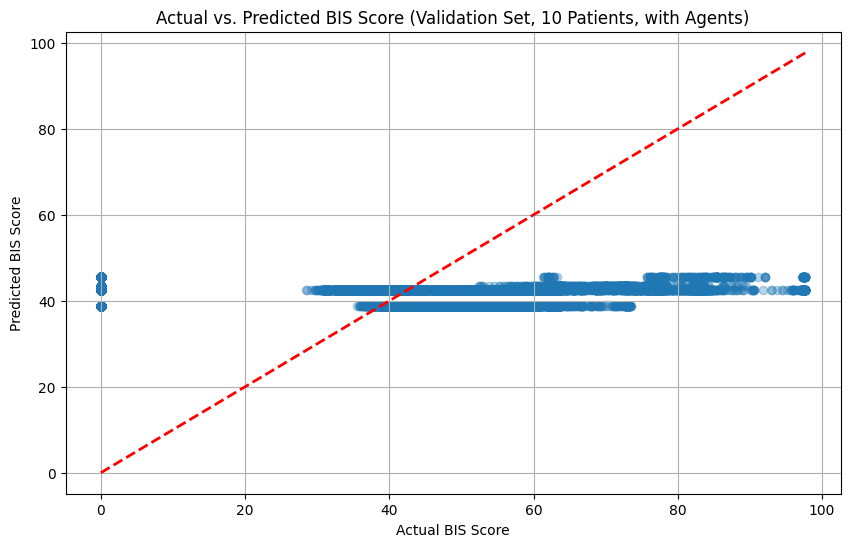


--- Phase 4: Generating Combined Average Graph ---
Concatenating raw data from 10 patients for averaging...
Calculating average and standard deviation across all patients...


In [ ]:
!pip install vitaldb matplotlib awscli xgboost scikit-learn --quiet

# Step 5: Incorporate Anesthetic Agent Features (10 Patients)

import os
import vitaldb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Configuration Parameters ---
VITAL_FILES_LOCAL_DIR = 'vital_files_full_dataset_1000' # Directory where files are downloaded
MODEL_SAVE_PATH = 'vitaldb_bis_model_test_10_patients_with_agents.json' # New path for this test model

INPUT_VITALS = [
    'Solar8000/HR',
    'Solar8000/ART_MBP',
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2',
    # --- NEW ANESTHETIC AGENT FEATURES ---
    'Primus/INSP_SEVO',
    'Primus/EXP_SEVO',
    'Primus/INSP_DES',
    'Primus/EXP_DES',
    'Primus/SET_AGE'
]
TARGET_VITAL = 'BIS/BIS'

# Tracks to load for feature engineering (inputs + target + event for potential debugging/plotting)
TRACKS_FOR_MODEL = INPUT_VITALS + [TARGET_VITAL, 'EVENT']
ROLLING_WINDOW_SIZE = 300 # 5 minutes in seconds for feature engineering
TRAIN_TEST_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
RANDOM_SEED = 42 # For reproducibility

NUM_PATIENTS_TO_PROCESS = 10 # Limit to 10 patients for this test run

# --- Helper Functions (from previous code) ---
def calculate_slope(y):
    """Calculates the slope of a series, handling NaNs."""
    y_clean = y.dropna()
    if len(y_clean) < 2:
        return np.nan
    return np.polyfit(np.arange(len(y_clean)), y_clean, 1)[0]

def generate_patient_features(case_ids: list, vital_files_dir: str, tracks_to_load: list,
                               window_size: int, input_vitals: list, target_vital: str):
    """
    Generator function to load patient data, engineer features, and yield processed DataFrames.
    """
    feature_cols_template = []
    for col in input_vitals:
        feature_cols_template.extend([
            f'{col}_mean', f'{col}_std', f'{col}_min', f'{col}_max', f'{col}_trend'
        ])

    for i, case_id in enumerate(case_ids):
        case_filename = f'{case_id:04d}.vital'
        file_path = os.path.join(vital_files_dir, case_filename)

        if not os.path.exists(file_path):
            print(f"Warning: File '{file_path}' not found for Case {case_id}. Skipping.")
            continue

        try:
            vf = vitaldb.VitalFile(file_path)
            df_raw = vf.to_pandas(tracks_to_load, interval=1)

            df_model = df_raw.copy()

            for col in input_vitals:
                # Check if the column exists in the DataFrame before applying rolling functions
                if col in df_model.columns:
                    df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
                    df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
                    df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
                    df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
                    df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)
                else:
                    # If a track is not present in a specific file, fill its features with NaNs
                    for suffix in ['_mean', '_std', '_min', '_max', '_trend']:
                        df_model[f'{col}{suffix}'] = np.nan


            feature_cols = [f for f in feature_cols_template if f in df_model.columns]
            final_cols = feature_cols + [target_vital]
            df_processed = df_model[final_cols].copy()

            df_processed = df_processed.dropna(subset=[target_vital]).dropna(how='all', subset=feature_cols)

            if not df_processed.empty:
                yield df_processed
            else:
                print(f"No valid data points after feature engineering for Case {case_id}. Skipping.")

        except Exception as e:
            print(f"Error processing Case {case_id}: {e}. Skipping.")

# --- Test Execution for Step 5 ---
print(f"--- Step 5: XGBoost Training Test (First {NUM_PATIENTS_TO_PROCESS} Patients, with Anesthetic Agents) ---")

# Ensure the directory for downloaded files exists
os.makedirs(VITAL_FILES_LOCAL_DIR, exist_ok=True)

# Download only the first NUM_PATIENTS_TO_PROCESS files if not already present
s3_source_path = 's3://physionet-open/vitaldb/1.0.0/vital_files/'
for i in range(1, NUM_PATIENTS_TO_PROCESS + 1):
    file_name = f'{i:04d}.vital'
    local_file_path = os.path.join(VITAL_FILES_LOCAL_DIR, file_name)
    if not os.path.exists(local_file_path):
        single_file_s3_path = os.path.join(s3_source_path, file_name)
        single_download_command = f'aws s3 cp --no-sign-request {single_file_s3_path} {local_file_path}'
        os.system(single_download_command)
        print(f"Downloaded {file_name}")
print(f"Download of first {NUM_PATIENTS_TO_PROCESS} files complete (or skipped if already present).")


# Use only the first NUM_PATIENTS_TO_PROCESS for training
all_case_ids = list(range(1, NUM_PATIENTS_TO_PROCESS + 1))

# Split case IDs into training and validation sets (patient-level split)
train_case_ids, val_case_ids = train_test_split(
    all_case_ids, test_size=(1 - TRAIN_TEST_SPLIT_RATIO), random_state=RANDOM_SEED
)

print(f"Total cases for training/validation: {len(all_case_ids)}")
print(f"Training cases (randomly selected patient IDs): {len(train_case_ids)}")
print(f"Validation cases (randomly selected patient IDs): {len(val_case_ids)}")

# Collect training data with progress updates
print("\nCollecting training data...")
X_train_list = []
y_train_list = []
for i, df_patient in enumerate(generate_patient_features(train_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_train_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_train_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 2 == 0 or (i + 1) == len(train_case_ids): # Update more frequently for 10 patients
        print(f"  Processed {i+1}/{len(train_case_ids)} training patients. Current data points: {sum(len(x) for x in X_train_list)}")

if not X_train_list:
    print("No training data collected. Cannot proceed with training.")
    exit()

X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

# Collect validation data with progress updates
print("\nCollecting validation data...")
X_val_list = []
y_val_list = []
for i, df_patient in enumerate(generate_patient_features(val_case_ids, VITAL_FILES_LOCAL_DIR, TRACKS_FOR_MODEL,
                                            ROLLING_WINDOW_SIZE, INPUT_VITALS, TARGET_VITAL)):
    X_val_list.append(df_patient.drop(columns=[TARGET_VITAL]))
    y_val_list.append(df_patient[TARGET_VITAL])
    if (i + 1) % 1 == 0 or (i + 1) == len(val_case_ids): # Update for every validation patient
        print(f"  Processed {i+1}/{len(val_case_ids)} validation patients. Current data points: {sum(len(x) for x in X_val_list)}")

if not X_val_list:
    print("No validation data collected. Cannot evaluate model.")
    X_val = pd.DataFrame()
    y_val = pd.Series()
else:
    X_val = pd.concat(X_val_list, ignore_index=True)
    y_val = pd.concat(y_val_list, ignore_index=True)
    print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")


print("\nTraining XGBoost Regressor model with validation monitoring...")
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',
    early_stopping_rounds=20
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          verbose=True
         )
print("Model training complete.")

# Save the trained model
model.save_model(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Evaluate the model
if not X_val.empty:
    print("\nFinal model evaluation on validation set...")
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation R-squared: {r2:.2f}")

    # Plotting predictions vs actual for a subset
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.3)
    min_val = min(y_val.min(), y_pred.min())
    max_val = max(y_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel("Actual BIS Score")
    plt.ylabel("Predicted BIS Score")
    plt.title(f"Actual vs. Predicted BIS Score (Validation Set, {NUM_PATIENTS_TO_PROCESS} Patients, with Agents)")
    plt.grid(True)
    plt.show()
else:
    print("Skipping final model evaluation as no validation data was collected.")

# --- Phase 4: Combined Graph (Vectorization/Averaging) ---
# This part is included for completeness but will be based on 10 patients for this test.
print(f"\n--- Phase 4: Generating Combined Average Graph ---")

AVERAGE_PLOT_TRACKS = INPUT_VITALS + [TARGET_VITAL]

all_patient_raw_dfs = []
print(f"Collecting raw data from all {NUM_PATIENTS_TO_PROCESS} patients for averaging...")
for case_id in all_case_ids:
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(VITAL_FILES_LOCAL_DIR, case_filename)

    if not os.path.exists(file_path):
        continue

    try:
        vf = vitaldb.VitalFile(file_path)
        df_raw_avg = vf.to_pandas(AVERAGE_PLOT_TRACKS, interval=1)
        all_patient_raw_dfs.append(df_raw_avg)
    except Exception as e:
        print(f"Error loading raw data for averaging for Case {case_id}: {e}. Skipping.")

if not all_patient_raw_dfs:
    print("No data collected for combined average graph. Skipping.")
else:
    print(f"Concatenating raw data from {len(all_patient_raw_dfs)} patients for averaging...")
    combined_raw_df = pd.concat(all_patient_raw_dfs, ignore_index=False)

    print("Calculating average and standard deviation across all patients...")
    average_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].mean()
    std_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].std()
    count_df = combined_raw_df.groupby(level=0)[AVERAGE_PLOT_TRACKS].count()

    fig_avg, axes_avg = plt.subplots(len(AVERAGE_PLOT_TRACKS), 1, figsize=(18, 5 * len(AVERAGE_PLOT_TRACKS)), sharex=True)
    fig_avg.suptitle(f'Average Vital Signs Across {NUM_PATIENTS_TO_PROCESS} Patients', fontsize=18)

    for i, track in enumerate(AVERAGE_PLOT_TRACKS):
        ax = axes_avg[i] if len(AVERAGE_PLOT_TRACKS) > 1 else axes_avg
        ax.plot(average_df.index, average_df[track], label=f'Average {track.split("/")[-1]}', color='blue')
        ax.fill_between(std_df.index, average_df[track] - std_df[track], average_df[track] + std_df[track],
                        color='blue', alpha=0.2, label='±1 Std Dev')
        ax.set_ylabel(track.split('/')[-1])
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax_twin_count = ax.twinx()
        ax_twin_count.plot(count_df.index, count_df[track], color='gray', linestyle=':', alpha=0.5, label='N Patients')
        ax_twin_count.set_ylabel('N Patients', color='gray')
        ax_twin_count.tick_params(axis='y', labelcolor='gray')
        ax_twin_count.legend(loc='upper left')


    axes_avg[-1].set_xlabel('Time (seconds from start of recording)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    print("Combined average graph generated.")

# --- Individual PDF generation (uncomment if needed) ---
# from matplotlib.backends.backend_pdf import PdfPages
#
# print(f"\n--- Generating individual patient plots PDF (up to {NUM_PATIENTS_TO_PROCESS} pages) ---")
# INDIVIDUAL_PDF_OUTPUT_DIR = 'individual_patient_pdfs_3_subplots'
# os.makedirs(INDIVIDUAL_PDF_OUTPUT_DIR, exist_ok=True)
# individual_pdf_path = os.path.join(INDIVIDUAL_PDF_OUTPUT_DIR, f'all_patient_vitals_3_subplots_{NUM_PATIENTS_TO_PROCESS}_patients.pdf')
#
# def plot_and_save_single_patient_pdf(case_id: int, vital_files_dir: str, pdf_pages: PdfPages):
#     case_filename = f'{case_id:04d}.vital'
#     file_path = os.path.join(vital_files_dir, case_filename)
#
#     print(f"Plotting Case {case_id} for PDF...")
#
#     if not os.path.exists(file_path):
#         print(f"ERROR: File '{file_path}' not found for Case {case_id}. Skipping PDF page.")
#         return
#
#     try:
#         vf = vitaldb.VitalFile(file_path)
#
#         tracks_to_load_plot = [
#             'Solar8000/HR',
#             'Solar8000/ART_MBP',
#             'Solar8000/PLETH_SPO2',
#             'Solar8000/ETCO2',
#             'BIS/BIS',
#             'EVENT'
#         ]
#
#         df = vf.to_pandas(tracks_to_load_plot, interval=1)
#
#         start_time, end_time = df.index.min(), df.index.max()
#         if 'Solar8000/ART_MBP' in df.columns:
#             valid_start = df['Solar8000/ART_MBP'].first_valid_index()
#             valid_end = df['Solar8000/ART_MBP'].last_valid_index()
#             if valid_start is not None and valid_end is not None:
#                 start_time = valid_start
#                 end_time = valid_end
#         start_time = max(df.index.min(), start_time - 300)
#         end_time = min(df.index.max(), end_time + 300)
#
#         events = df['EVENT'].dropna()
#
#         fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
#         fig.suptitle(f'Comprehensive Patient View (Case {case_id:04d})', fontsize=18)
#
#         ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
#         ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
#         ax1.set_ylabel('Core Vitals')
#         ax1.legend(loc='upper left')
#         ax1.grid(True, linestyle='--', alpha=0.6)
#         ax1.set_ylim(0, 150)
#
#         ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
#         ax2.set_ylabel('SpO2 (%)', color='darkcyan')
#         ax2.tick_params(axis='y', labelcolor='darkcyan')
#         ax2.set_ylim(85, 101)
#
#         ax2_twin = ax2.twinx()
#         ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
#         ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold')
#         ax2_twin.tick_params(axis='y', labelcolor='gold')
#         ax2_twin.set_ylim(0, 60)
#
#         lines, labels = ax2.get_legend_handles_labels()
#         lines2, labels2 = ax2_twin.get_legend_handles_labels()
#         ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
#         ax2.grid(True, linestyle='--', alpha=0.6)
#
#         ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
#         ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
#         ax3.set_ylabel('Anesthetic Depth (BIS)')
#         ax3.legend(loc='upper left')
#         ax3.grid(True, linestyle='--', alpha=0.6)
#         ax3.set_ylim(0, 100)
#
#         for time, text in events.items():
#             for ax in [ax1, ax2, ax3]:
#                 ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
#             ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)
#
#         ax1.set_xlim(start_time, end_time)
#
#         plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#         pdf_pages.savefig(fig)
#         plt.close(fig)
#         print(f"Successfully added Case {case_id} to PDF.")
#
#     except Exception as e:
#         print(f"Error plotting Case {case_id} for PDF: {e}")
#
# with PdfPages(individual_pdf_path) as pdf:
#     for case_id in range(1, NUM_PATIENTS_TO_PROCESS + 1):
#         plot_and_save_single_patient_pdf(case_id, VITAL_FILES_LOCAL_DIR, pdf)
# print(f"Individual patient plots combined into: {individual_pdf_path}")